# pyIsoDep

Copyright (c) Dan Kotlyar <br>
Author: Matt Krecicki

# Analytical Validation

##  Description

Analytical validation cases to ensure accurate solutions. Simplified xenon and samarium chains are used as benchmark problems.

## Load modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyIsoDep.functions.maindepletionsolver import MainDepletion
from pyIsoDep.functions.generatedata import TransmutationData
from pyIsoDep.functions.postprocessresults import Results

#### Analytical solution functions

In [2]:
def analyticalIodine(timepoints, I0, SIG_F, flx, lmdaI, fyI):
    return ((fyI*SIG_F*flx) / lmdaI) * (1-np.exp(-lmdaI*timepoints)) * 1E-24


def analyticalXenon(timepoints, I0, X0, sigaX, SIG_F, flx, lmdaI, lmdaX, fyI, fyX):
    return ((fyI+fyX)*SIG_F*flx/(lmdaX+sigaX*flx*1E-24)*(
        1-np.exp((-lmdaX-sigaX*flx*1E-24)*timepoints)) +\
        (fyI*SIG_F*flx-lmdaI*I0)/(lmdaX-lmdaI+sigaX*flx*1E-24)*(
            np.exp((-lmdaX-sigaX*1E-24*flx)*timepoints)-np.exp(-lmdaI*timepoints)) +\
        X0*np.exp((-lmdaX-sigaX*flx*1E-24)*timepoints))*1E-24


def analyticalPromethium(timepoints, Pm0, fyPm, SIG_F, flx, lmdaPm):
    return ((((fyPm * SIG_F * flx) / lmdaPm) * (1 - np.exp(-1*lmdaPm*timepoints))) +\
        (Pm0 * np.exp(-1*lmdaPm*timepoints)))*1E-24


def analyticalSamarium(timepoints, Pm0, Sm0, fyPm, sigaSm, SIG_F, flx, lmdaPm):   
    return 1E-24*((Sm0*np.exp(-1*sigaSm*flx*timepoints)) + ((lmdaPm * SIG_F/sigaSm)*\
        (1 - np.exp(-1*sigaSm*flx*timepoints))) - (((lmdaPm * SIG_F* flx - lmdaPm*Pm0)\
            /(lmdaPm - sigaSm*flx))*(np.exp(-1*sigaSm*flx*timepoints)-np.exp(-1*lmdaPm*timepoints))))
 
    
def analyticalIodineDecay(timepoints, I0, lmdaI):
    return I0 * np.exp(-1*lmdaI*timepoints)


def analyticalXenonDecay(timepoints, I0, Xe0, lmdaI, lmdaXe):
    return(Xe0 * np.exp(-lmdaXe*timepoints)) + (I0 * (lmdaI / (lmdaI - lmdaXe)) *\
        (np.exp(-lmdaXe*timepoints) - np.exp(-lmdaI*timepoints)))
    

def analyticalPromethiumDecay(timepoints, Pm0, lmdaPm):
    return Pm0 * np.exp(-1*lmdaPm*timepoints)


def analyticalSamariumDecay(timepoints, Pm0, Sm0, lmdaPm, lmdaSm):
    return Sm0 + Pm0*(1 - np.exp(-1*lmdaPm*timepoints))

## Depletion Analytical Validation

This section compares analytical and numerical depletion analysis for a simplified xenon and samarium chain

#### Data Generation Stage

In [3]:
ID =    [531350, 541350, 611490, 621490,   922350]
sig_c = [0.0,    2.5E+5, 0.0,    2.0E+3,   0.0]
sig_f = [0.0,    0.0,    0.0,    0.0,      97.]
kappa = [0.0,    0.0,    0.0,    0.0,      202.44]
N0 =    [0.0,    0.0,    0.0,    0.0,      6.43230E-04]

#build decay matrix 

#         531350,          541350,         611490,         621490,         922350
dcMtx =  [
         [-2.93061e-05,    0.000000000,    0.000000000,    0.000000000,    0.000000000],  # 531350
         [ 2.93061e-05,   -2.10657e-05,    0.000000000,    0.000000000,    0.000000000],  # 541350
         [ 0.000000000,    0.000000000,   -3.626825E-6,    0.000000000,    0.000000000],  # 611490
         [ 0.000000000,    0.000000000,    3.626825E-6,    0.000000000,    0.000000000],  # 621490
         [ 0.000000000,    0.000000000,    0.000000000,    0.000000000,    0.000000000],  # 922350
         ]

#build fission yield matrix

#         531350,          541350,         611490,         621490,         922350
fyMtx =  [
         [ 0.000000000,    0.000000000,    0.000000000,    0.000000000,    0.06306],  # 531350
         [ 0.000000000,    0.000000000,    0.000000000,    0.000000000,    0.00248],  # 541350
         [ 0.000000000,    0.000000000,    0.000000000,    0.000000000,    0.01100],  # 611490
         [ 0.000000000,    0.000000000,    0.000000000,    0.000000000,    0.00000],  # 621490
         [ 0.000000000,    0.000000000,    0.000000000,    0.000000000,    0.00000],  # 922350
         ]

# build data container
data = TransmutationData(libraryFlag=True, wgtFY=1.0)
data.ReadData(ID, sig_f=sig_f, sig_c=sig_c, fymtx=fyMtx, EfissMeV=kappa, decaymtx=dcMtx)
data.Condense(ID) # Condense the data only to specific set of isotopes

#### Define metadata

In [4]:
nsteps = 15
timeBurn = 30.0
timePoints = np.linspace(0, timeBurn, nsteps)
flux =4.0E+14*np.ones(len(timePoints)-1) #n/cm2-s
volume = 1.0  # volume in cm**3
timeUnits = "minutes"

#### Execute Depletion

In [5]:
depCram = MainDepletion(0.0, data)
depCram.SetDepScenario(flux=flux, timeUnits=timeUnits, timepoints=timePoints)
depCram.SetInitialComposition(ID, N0, vol=volume)
depCram.SolveDepletion(method="cram")
depCram.DecayHeat()
depCram.Radiotoxicity()
depCram.Activity()
depCram.Mass()

depExpm = MainDepletion(0.0, data)
depExpm.SetDepScenario(flux=flux, timeUnits=timeUnits, timepoints=timePoints)
depExpm.SetInitialComposition(ID, N0, vol=volume)
depExpm.SolveDepletion(method="expm")
depExpm.DecayHeat()
depExpm.Radiotoxicity()
depExpm.Activity()
depExpm.Mass()

depOde = MainDepletion(0.0, data)
depOde.SetDepScenario(flux=flux, timeUnits=timeUnits, timepoints=timePoints)
depOde.SetInitialComposition(ID, N0, vol=volume)
depOde.SolveDepletion(method="odeint")
depOde.DecayHeat()
depOde.Radiotoxicity()
depOde.Activity()
depOde.Mass()

depAdpt = MainDepletion(0.0, data)
depAdpt.SetDepScenario(flux=flux, timeUnits=timeUnits, timepoints=timePoints)
depAdpt.SetInitialComposition(ID, N0, vol=volume)
depAdpt.SolveDepletion(method="adaptive")
depAdpt.DecayHeat()
depAdpt.Radiotoxicity()
depAdpt.Activity()
depAdpt.Mass()


#get analytical results
time = timePoints*60
IRef = analyticalIodine(time, N0[0], N0[4]*sig_f[4], flux[0], abs(dcMtx[0][0]), fyMtx[0][4])
XeRef = analyticalXenon(time, N0[0], N0[1], sig_c[1]*1E-24, N0[4]*sig_f[4], flux[0],\
                        abs(dcMtx[0][0]), abs(dcMtx[1][1]), fyMtx[0][4], fyMtx[1][4])
PmRef = analyticalPromethium(time, N0[2], fyMtx[2][4], N0[4]*sig_f[4], flux[0], abs(dcMtx[2][2]))
SmRef = analyticalSamarium(time, N0[2], N0[3], fyMtx[2][4], sig_c[3]*1E-24, N0[4]*sig_f[4], flux[0], abs(dcMtx[2][2]))

### Post-process and compare analytical results

In [6]:
resCram = Results(depCram)
resExpm = Results(depExpm)
resOde = Results(depOde)
resAdpt = Results(depAdpt)

In [7]:
ICram = resCram.getvalues(isotopes=[531350], attribute="Nt")
IExpm = resExpm.getvalues(isotopes=[531350], attribute="Nt")
IOde =  resOde.getvalues(isotopes=[531350], attribute="Nt")
IAdpt = resAdpt.getvalues(isotopes=[531350], attribute="Nt")

XeCram = resCram.getvalues(isotopes=[541350], attribute="Nt")
XeExpm = resExpm.getvalues(isotopes=[541350], attribute="Nt")
XeOde =  resOde.getvalues(isotopes=[541350], attribute="Nt")
XeAdpt = resAdpt.getvalues(isotopes=[541350], attribute="Nt")

PmCram = resCram.getvalues(isotopes=[611490], attribute="Nt")
PmExpm = resExpm.getvalues(isotopes=[611490], attribute="Nt")
PmOde =  resOde.getvalues(isotopes=[611490], attribute="Nt")
PmAdpt = resAdpt.getvalues(isotopes=[611490], attribute="Nt")

SmCram = resCram.getvalues(isotopes=[621490], attribute="Nt")
SmExpm = resExpm.getvalues(isotopes=[621490], attribute="Nt")
SmOde =  resOde.getvalues(isotopes=[621490], attribute="Nt")
SmAdpt = resAdpt.getvalues(isotopes=[621490], attribute="Nt")


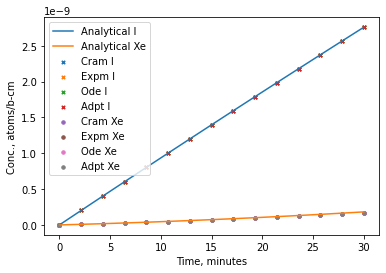

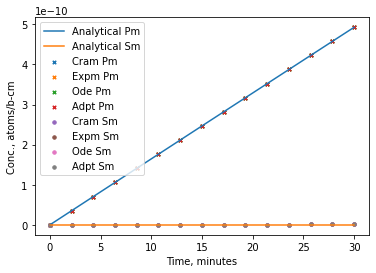

In [8]:
#compare iodine and xenon atomic concentrations

time = timePoints
plt.plot(time, IRef, label="Analytical I")
plt.scatter(time, ICram, label="Cram I", s=12, marker="x")
plt.scatter(time, IExpm, label="Expm I", s=12, marker="x")
plt.scatter(time, IOde, label="Ode I", s=12, marker="x")
plt.scatter(time, IAdpt, label="Adpt I", s=12, marker="x")
plt.plot(time, XeRef, label="Analytical Xe")
plt.scatter(time, XeCram, label="Cram Xe", s=12, marker="o")
plt.scatter(time, XeExpm, label="Expm Xe", s=12, marker="o")
plt.scatter(time, XeOde, label="Ode Xe", s=12, marker="o")
plt.scatter(time, XeAdpt, label="Adpt Xe", s=12, marker="o")
plt.xlabel("Time, minutes")
plt.ylabel("Conc., atoms/b-cm")
plt.legend()
plt.show()
plt.close()

#compare promethium and samarium atomic concentrations

plt.plot(time, PmRef, label="Analytical Pm")
plt.scatter(time, PmCram, label="Cram Pm", s=12, marker="x")
plt.scatter(time, PmExpm, label="Expm Pm", s=12, marker="x")
plt.scatter(time, PmOde, label="Ode Pm", s=12, marker="x")
plt.scatter(time, PmAdpt, label="Adpt Pm", s=12, marker="x")
plt.plot(time, SmRef, label="Analytical Sm")
plt.scatter(time, SmCram, label="Cram Sm", s=12, marker="o")
plt.scatter(time, SmExpm, label="Expm Sm", s=12, marker="o")
plt.scatter(time, SmOde, label="Ode Sm", s=12, marker="o")
plt.scatter(time, SmAdpt, label="Adpt Sm", s=12, marker="o")
plt.xlabel("Time, minutes")
plt.ylabel("Conc., atoms/b-cm")
plt.legend()
plt.show()
plt.close()


## Decay Analytical Valiadtion

This section details a decay problem, where the reactor power is set to zero.

#### Data Generation Stage

In [9]:
ID =    [531350, 541350, 611490, 621490]
sig_c = [0.0,    2.5E+5, 0.0,    2.0E+3]
sig_f = [0.0,    0.0,    0.0,    0.0]
kappa = [0.0,    0.0,    0.0,    0.0]
N0 =    [2.7594e-08,    1.8182e-09,    4.9255e-09,    5.2813e-15]

#build decay matrix 

#         531350,          541350,         611490,         621490
dcMtx =  [
         [-2.93061e-05,    0.000000000,    0.000000000,    0.000000000],  # 531350
         [ 2.93061e-05,   -2.10657e-05,    0.000000000,    0.000000000],  # 541350
         [ 0.000000000,    0.000000000,   -3.626825E-6,    0.000000000],  # 611490
         [ 0.000000000,    0.000000000,    3.626825E-6,    0.000000000],  # 621490
         ]

# build data container
data = TransmutationData(libraryFlag=True, wgtFY=1.0)
data.ReadData(ID, sig_f=sig_f, sig_c=sig_c, decaymtx=dcMtx)
data.Condense(ID) # Condense the data only to specific set of isotopes

In [10]:
#### Define metadata

In [11]:
nsteps = 100
timeDecay = 80
timePoints = np.linspace(0, timeDecay, nsteps)
flux = 0.0*np.ones(len(timePoints)-1) #n/cm2-s
volume = 1.0  # volume in cm**3
timeUnits = "hours"

In [12]:
depCram = MainDepletion(0.0, data)
depCram.SetDepScenario(flux=flux, timeUnits=timeUnits, timepoints=timePoints)
depCram.SetInitialComposition(ID, N0, vol=volume)
depCram.SolveDepletion(method="cram")
depCram.DecayHeat()
depCram.Radiotoxicity()
depCram.Activity()
depCram.Mass()

depExpm = MainDepletion(0.0, data)
depExpm.SetDepScenario(flux=flux, timeUnits=timeUnits, timepoints=timePoints)
depExpm.SetInitialComposition(ID, N0, vol=volume)
depExpm.SolveDepletion(method="expm")
depExpm.DecayHeat()
depExpm.Radiotoxicity()
depExpm.Activity()
depExpm.Mass()

depOde = MainDepletion(0.0, data)
depOde.SetDepScenario(flux=flux, timeUnits=timeUnits, timepoints=timePoints)
depOde.SetInitialComposition(ID, N0, vol=volume)
depOde.SolveDepletion(method="odeint")
depOde.DecayHeat()
depOde.Radiotoxicity()
depOde.Activity()
depOde.Mass()

depAdpt = MainDepletion(0.0, data)
depAdpt.SetDepScenario(flux=flux, timeUnits=timeUnits, timepoints=timePoints)
depAdpt.SetInitialComposition(ID, N0, vol=volume)
depAdpt.SolveDepletion(method="adaptive")
depAdpt.DecayHeat()
depAdpt.Radiotoxicity()
depAdpt.Activity()
depAdpt.Mass()

#get analytical results
time = timePoints*60*60

#         531350,          541350,         611490,         621490
dcMtx =  [
         [-2.93061e-05,    0.000000000,    0.000000000,    0.000000000],  # 531350
         [ 2.93061e-05,   -2.10657e-05,    0.000000000,    0.000000000],  # 541350
         [ 0.000000000,    0.000000000,   -3.626825E-6,    0.000000000],  # 611490
         [ 0.000000000,    0.000000000,    3.626825E-6,    0.000000000],  # 621490
         ]


IRef = analyticalIodineDecay(time, N0[0], abs(dcMtx[0][0]))
XeRef = analyticalXenonDecay(time, N0[0], N0[1], abs(dcMtx[0][0]), abs(dcMtx[1][1]))
PmRef = analyticalPromethiumDecay(time, N0[2], abs(dcMtx[2][2]))
SmRef = analyticalSamariumDecay(time, N0[2], N0[3], abs(dcMtx[2][2]), abs(dcMtx[3][3]))

In [13]:
resCram = Results(depCram)
resExpm = Results(depExpm)
resOde = Results(depOde)
resAdpt = Results(depAdpt)

In [14]:
ICram = resCram.getvalues(isotopes=[531350], attribute="Nt")
IExpm = resExpm.getvalues(isotopes=[531350], attribute="Nt")
IOde =  resOde.getvalues(isotopes=[531350], attribute="Nt")
IAdpt = resAdpt.getvalues(isotopes=[531350], attribute="Nt")

XeCram = resCram.getvalues(isotopes=[541350], attribute="Nt")
XeExpm = resExpm.getvalues(isotopes=[541350], attribute="Nt")
XeOde =  resOde.getvalues(isotopes=[541350], attribute="Nt")
XeAdpt = resAdpt.getvalues(isotopes=[541350], attribute="Nt")

PmCram = resCram.getvalues(isotopes=[611490], attribute="Nt")
PmExpm = resExpm.getvalues(isotopes=[611490], attribute="Nt")
PmOde =  resOde.getvalues(isotopes=[611490], attribute="Nt")
PmAdpt = resAdpt.getvalues(isotopes=[611490], attribute="Nt")

SmCram = resCram.getvalues(isotopes=[621490], attribute="Nt")
SmExpm = resExpm.getvalues(isotopes=[621490], attribute="Nt")
SmOde =  resOde.getvalues(isotopes=[621490], attribute="Nt")
SmAdpt = resAdpt.getvalues(isotopes=[621490], attribute="Nt")

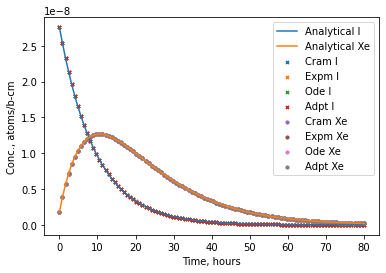

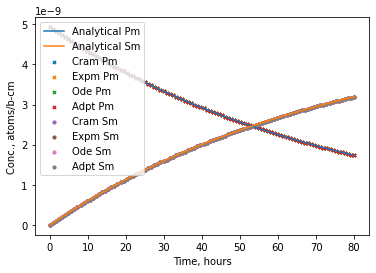

In [15]:
time = timePoints
plt.plot(time, IRef, label="Analytical I")
plt.scatter(time, ICram, label="Cram I", s=10, marker="x")
plt.scatter(time, IExpm, label="Expm I", s=10, marker="x")
plt.scatter(time, IOde, label="Ode I", s=10, marker="x")
plt.scatter(time, IAdpt, label="Adpt I", s=10, marker="x")
plt.plot(time, XeRef, label="Analytical Xe")
plt.scatter(time, XeCram, label="Cram Xe", s=10, marker="o")
plt.scatter(time, XeExpm, label="Expm Xe", s=10, marker="o")
plt.scatter(time, XeOde, label="Ode Xe", s=10, marker="o")
plt.scatter(time, XeAdpt, label="Adpt Xe", s=10, marker="o")
plt.xlabel("Time, hours")
plt.ylabel("Conc., atoms/b-cm")
plt.legend()
plt.show()
plt.close()

plt.plot(time, PmRef, label="Analytical Pm")
plt.scatter(time, PmCram, label="Cram Pm", s=10, marker="x")
plt.scatter(time, PmExpm, label="Expm Pm", s=10, marker="x")
plt.scatter(time, PmOde, label="Ode Pm", s=10, marker="x")
plt.scatter(time, PmAdpt, label="Adpt Pm", s=10, marker="x")
plt.plot(time, SmRef, label="Analytical Sm")
plt.scatter(time, SmCram, label="Cram Sm", s=10, marker="o")
plt.scatter(time, SmExpm, label="Expm Sm", s=10, marker="o")
plt.scatter(time, SmOde, label="Ode Sm", s=10, marker="o")
plt.scatter(time, SmAdpt, label="Adpt Sm", s=10, marker="o")
plt.xlabel("Time, hours")
plt.ylabel("Conc., atoms/b-cm")
plt.legend()
plt.show()
plt.close()